# Smoothing exposure corrected images


Often users will simply smooth their exposure corrected images, $F$.  This is not correct.  Users should be
individually smoothing the counts image, $C$,  and the exposure map, $E$, and then dividing.

That is if we have

$F = \frac{C}{E}$

then for smoothing kernel $G$, 

$\bar{F} = \frac{ G \circledast C}{G \circledast E} \neq G \circledast \frac{C}{E} $


If counts=0, then the exposure at that location is not included when smoothed.  Suppose counts=0 because expsoure=0.
In the smoothed output the signal will be artificially low since only the info about the lower counts is taken 
into account; we've lost the info that the exposure is low which (in this example) would compensate for the low counts.

When $G$ is an adaptive smoothing, then there are other considerations.

This notebook shows how to use the CIAO `dmimgadapt` tool to correctly smooth the counts and exposure map
to obtain a properly smoothed expsoure corrected (aka _fluxed_ image).


## Setup

Download, reprocess, and create images.

In [1]:
source /export/ciao/bin/ciao.bash -o

CIAO configuration is complete... 
The CIAO setup for this window has changed from
CIAO 4.10 Thursday, April 12, 2018
  bindir      : /export/ciao-4.10/bin
  CALDB       : 4.7.8
To:
CIAO 4.10 Thursday, April 12, 2018
  bindir      : /export/ciao-4.10/bin
  CALDB       : 4.7.8


In [2]:
/bin/rm -rf 19522
download_chandra_obsid 19522 evt1,flt,msk,pbk,bias,dtf,fov,bpix,mtl,asol,stat


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  asol     fits        9 Mb  ####################          < 1 s  91657.8 kb/s
  bpix     fits       53 Kb  ####################          < 1 s  6052.8 kb/s
  fov      fits        5 Kb  ####################          < 1 s  869.8 kb/s
  stat     fits      923 Kb  ####################          < 1 s  38630.5 kb/s
  mtl      fits        2 Mb  ####################          < 1 s  49232.5 kb/s
  evt1     fits       51 Mb  ####################          < 1 s  108227.4 kb/s
  flt      fits        6 Kb  ####################          < 1 s  870.6 kb/s
  msk      fits        5 Kb  ####################          < 1 s  695.5 kb/s
  bias     fits      436 Kb  ####################          < 1 s  27406.6 kb/s
  bias     fits      436 Kb  ####################          < 1 s  26140.0 kb/s
  bias     fits      437 Kb  ####################          

In [3]:
chandra_repro 19522 19522/repro


Processing input directory '/data/lenin2/Projects/SmoothExposureSeparately/19522'

Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /data/lenin2/Projects/SmoothExposureSeparately/19522/repro/acisf19522_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...
Setting observation-specific bad pixel file in local ardlib.par.

Cleaning up intermediate files

         /data/lenin2/Projects/SmoothExposureSeparately/19522/repro/acisf19522_repro_bpix1.fits
         Run 'punlearn ardlib' when analysis of this dataset completed.

The data have been reprocessed.
Start your analysis with the new products in
/data/lenin2/Projects/SmoothExposureSeparately/19

In [4]:
fluximage 19522/repro out=m51 band=broad bin=4 mode=h clob+

Running fluximage
Version: 12 September 2016

Found 19522/repro/acisf19522_repro_evt2.fits
Using event file 19522/repro/acisf19522_repro_evt2.fits
Using CSC ACIS broad science energy band.
Aspect solution 19522/repro/pcadf606099472N001_asol1.fits found.
Bad-pixel file 19522/repro/acisf19522_repro_bpix1.fits found.
Mask file 19522/repro/acisf19522_001N001_msk1.fits found.

The output images will have 728 by 727 pixels, pixel size of 1.968 arcsec,
    and cover x=2588.5:5500.5:4,y=2720.5:5628.5:4.

Running tasks in parallel with 4 processors.
Creating aspect histograms for obsid 19522
Creating 4 instrument maps for obsid 19522
Creating 4 exposure maps for obsid 19522
Combining 4 exposure maps for obsid 19522
Thresholding data for obsid 19522
Exposure-correcting image for obsid 19522

The following files were created:

 The clipped counts image is:
     m51_broad_thresh.img

 The clipped exposure map is:
     m51_broad_thresh.expmap

 The exposure-corrected image is:
     m51_broad_flux.i

## Apply FOV file

I'm going to filter the counts image `m51_broad_thresh.img` and the exposure map `m51_broad_thresh.expmap` with the field-of-view file.

**Why?**

It does not filter out any of the actual data in either file; however, the boundary of the FOV get written into the
files and `dmimgadapt` knows how to use it.  The practical upshot is that it stops smoothing at the edge of the detector
and as a result is also faster because it's not trying to use big smoothing kernels at the edge where it's all 0s.




In [5]:
dmcopy m51_broad_thresh.img"[sky=region(19522/repro/acisf19522_repro_fov1.fits)][opt full]" img.fits clob+

In [6]:
dmcopy m51_broad_thresh.expmap"[sky=region(19522/repro/acisf19522_repro_fov1.fits)][opt full]" exp.fits clob+

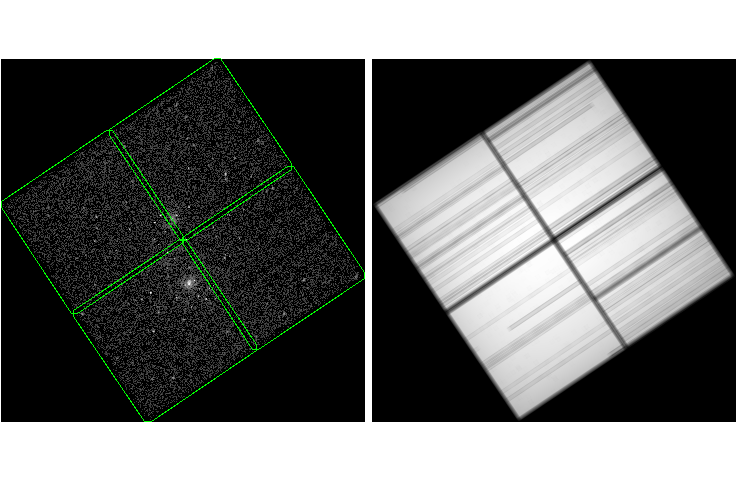

In [7]:
ds9 img.fits -region 19522/repro/acisf19522_repro_fov1.fits -scale log -block 2 exp.fits -scale linear \
  -view colorbar no \
  -saveimage png ds9_01.png -quit

display < ds9_01.png

    Left: broad band counts image for obsid 19522 with the field-of-view file drawn around each of
    the 4 ACIS-I chips.  Right: The broad-band exposure map, note the lower exposure 
    in the gap between the chips and the various bad columns. 

## Adaptively smooth counts image

I prefer to use the `cone` instead of the `gaus` function, especially when doing testing since it runs much
faster.

In [8]:
punlearn dmimgadapt

In [9]:
dmimgadapt img.fits img.asm cone minrad=0.5 maxrad=30.0 numrad=120 radscale=linear counts=25 \
  sumfile=img.sum normfile=img.norm radfile=img.radii mode=h clob+ verb=0

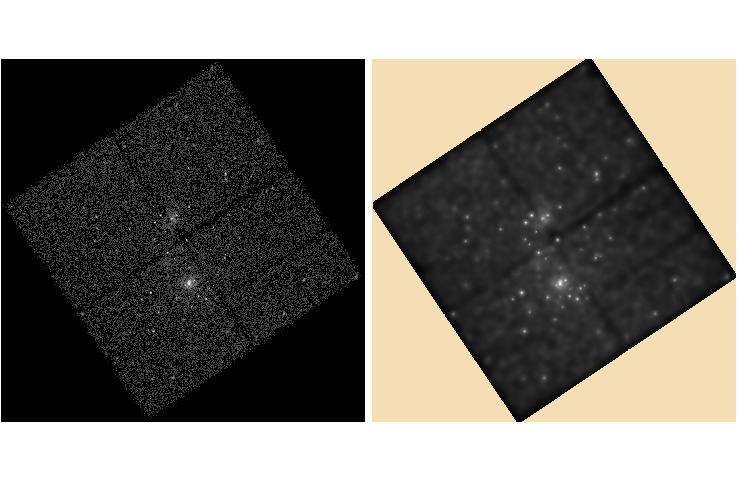

In [10]:
ds9 img.fits -scale log -nan wheat -block 2 img.asm \
  -view colorbar no \
  -saveimage png ds9_02.png -quit

display < ds9_02.png

    Left: broad band counts image.  Right: Adaptive smoothed image requiring 25 counts under the 
    convolution kernel.

> Note: I used the `-nan wheat` argument here to show that the pixels off the detector have 
> been properly excluded from the smoothing.

> Also note: `-export` rather than `-saveimage`.  `-saveimage` saves the image visible in the ds9 GUI, WYSIWYG.
> `-export` only applies the colormap to the (scaled, blocked, etc) image.  Colorbars and regions are not included.
 

### Check scale map

Always good to check this to see if the choice of smoothing scales was reasonable (eg need more smaller scales, 
or need larger scales to meet counts criteria).


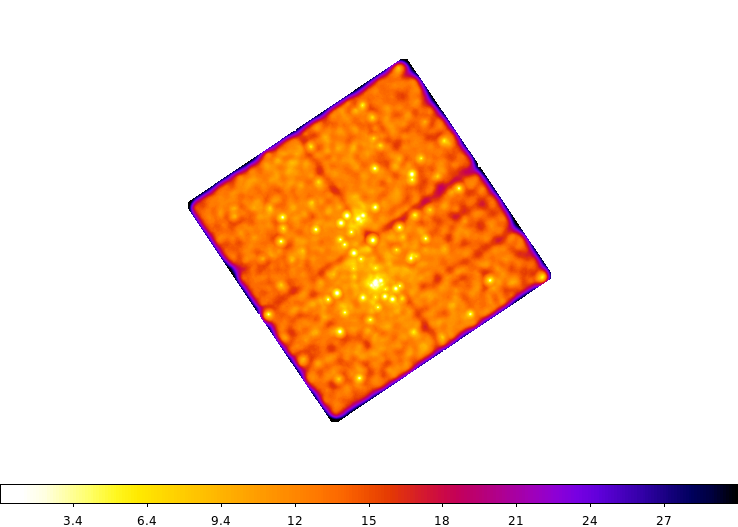

In [11]:
ds9 img.radii -scale linear -zoom 0.5 -cmap load $ASCDS_INSTALL/contrib/data/001-fire.lut -cmap invert yes \
  -saveimage ds9_05.png -quit 

display < ds9_05.png

    The smoothing scale map needed to obtain 25 counts per pixel using a cone shaped
    convolution kernel.  This looks reasonable in that I do not have a lot of pixels
    with only the smallest smoothing scale nor a lot of pixels with only the largest
    smoothing scale.
    

## Smooth exposure map with same scales

To do this correctly we need to keep this **important** distinction in mind.

1. In the counts image, `img.fits`, the pixel values represent the **integrated** counts within the pixel boundaries.
2. In the exposure map, `exp.fits`, the pixel values represent the **average** exposure within the pixel boundaries.

The trick to getting `dmimgadapt` to do this is to supply an input normalization file, `innormfile`, where all the 
pixels values are equal to `1`.


In [12]:
dmimgcalc exp.fits none ones.fits op="imgout=(img1-img1)+1" clob+

In [13]:
dmstat ones.fits cen- sig- med-

ones.fits
    min:	1 	      @:	( 3742.5 2722.5 )
    max:	1 	      @:	( 3742.5 2722.5 )
   mean:	1 
    sum:	282867 
   good:	282867 
   null:	246389 


OK, so we now have an image with all pixels equal to `1`.  This is used to get the correct
normalization to produce an _average_ exposure value per-pixel.

In [14]:
dmimgadapt exp.fits exp.asm cone inrad=img.radii innorm=ones.fits mode=h clob+ verb=0 

# dmimgadapt (CIAO 4.10): The following error occurred 246389 times:



_The warning is expected_.

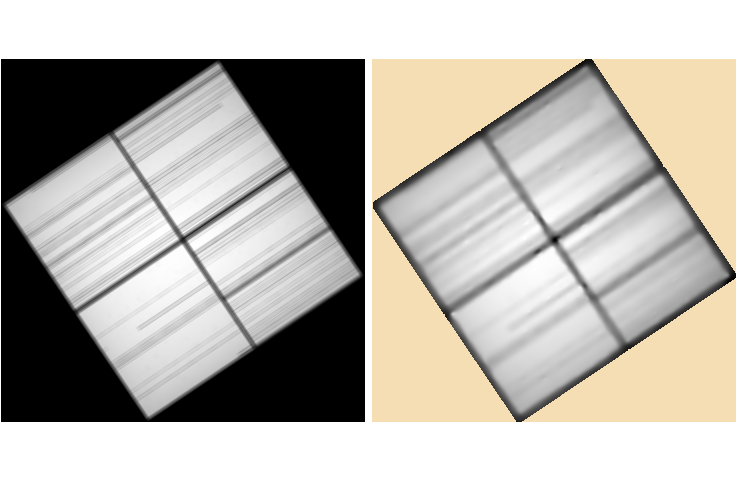

In [15]:
ds9 exp.fits -scale linear -nan wheat -block 2 exp.asm  \
  -view colorbar no \
  -saveimage png ds9_03.png -quit

display < ds9_03.png

    Left: broad-band exposure map.  Right: Adaptively smoothed exposure map using 
    input scale obtained from counts image.  The smoothing is most obvious along
    the chip gaps

In [16]:
dmimgcalc img.asm exp.asm flux.asm div clob+

_The warning is expected._

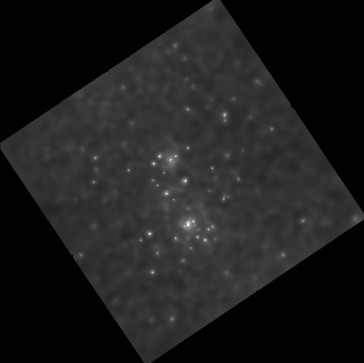

In [17]:
ds9 flux.asm -scale log -nan wheat -block 2 \
  -export png ds9_04.png -quit

display < ds9_04.png

    Exposure corrected, adaptively smoothed image created by smoothing the counts image and then using the 
    same smoothing scales to smooth the exposure map.

> Note: `dmimgcalc` does not copy the subspace, so the `NaN` values are 
> replaced with `0` (and thus rendered as black pixels).

### Omitting exposure map normalization 

aka the wrong way ...


In [18]:
dmimgadapt exp.fits wrong_exp.asm cone inrad=img.radii innorm= mode=h clob+ verb=0 

# dmimgadapt (CIAO 4.10): The following error occurred 246389 times:



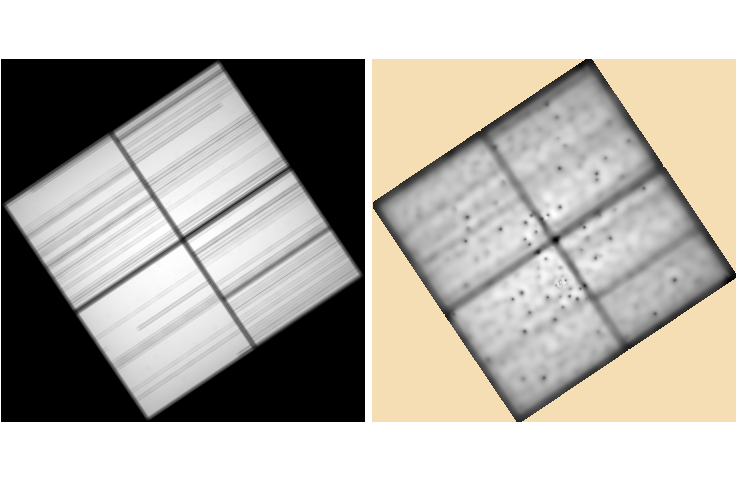

In [19]:
ds9 exp.fits -scale linear -nan wheat -block 2 wrong_exp.asm  \
  -view colorbar no \
  -saveimage png ds9_06.png -quit

display < ds9_06.png

    Left: Original exposure map.  Right: Adaptively smoothed exposure map created without
    using normalized weights.  The exposure map is artificially low where the 
    smoothing scales is small.   The net effect is that there is a double-correction 
    in the resulting exposure corrected image (low exposure means higher flux) in the 
    pixels at/around point sources

In [20]:
dmimgcalc img.asm wrong_exp.asm wrong_flux.asm div clob+

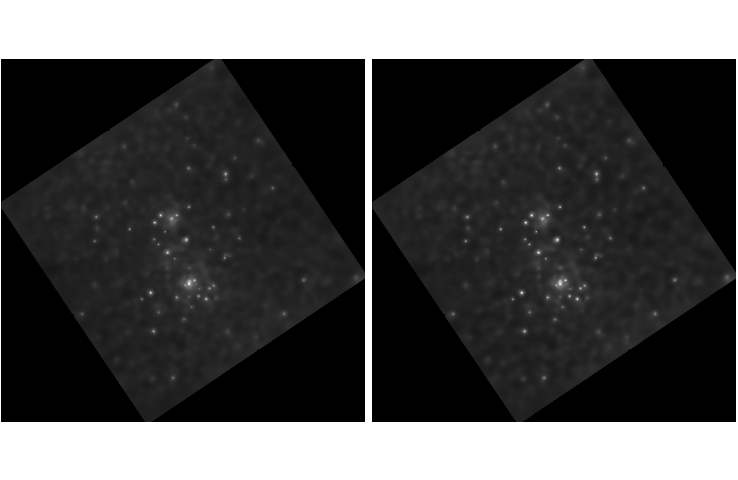

In [21]:
ds9 flux.asm -scale log -nan wheat -block 2 wrong_flux.asm  \
  -match scale -match scalelimits -match colorbar \
  -view colorbar no \
  -saveimage png ds9_07.png -quit

display < ds9_07.png

    Left: Correctly normalized exposure corrected image.  Right: incorrectly normalized exposure corrected image.
    Overall the two look similar; however, if we examine them more closely we can see where
    the flux in the incorrectly normalized image is over-estimated (due to low exposure)
    

In [22]:
dmimgcalc flux.asm wrong_flux.asm diff_flux.asm sub clob+

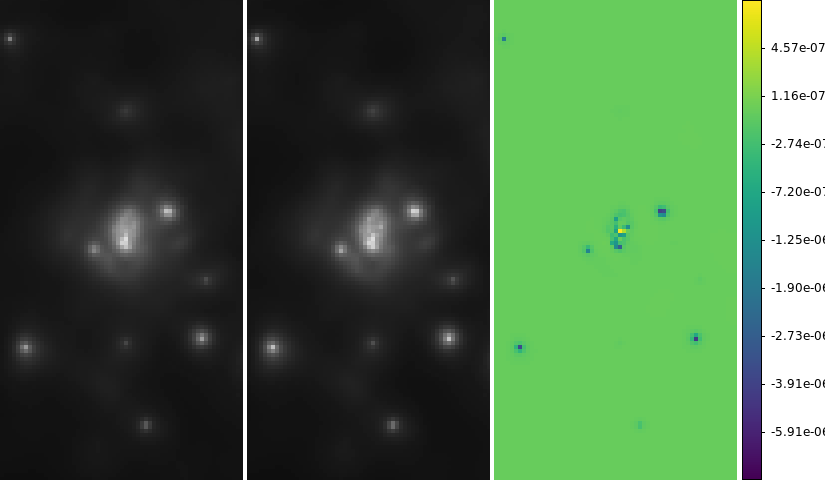

In [23]:
ds9 flux.asm -scale log -nan wheat -zoom 4 -pan to 4090 3825 physical \
  wrong_flux.asm  -pan to 4090 3825 physical \
  -match scale -match scalelimits -match colorbar \
  diff_flux.asm  -pan to 4090 3825 physical  -scale pow \
  -cmap viridis -colorbar vertical \
  -tile mode column \
  -saveimage png ds9_08.png -quit

display < ds9_08.png

    Left: Correctly normalized exposure corrected image.  Center: Incorrectly normalized
    exposure corrected image.  Right: Difference between the two.  We can see in the
    difference image what amounts to essential an "unsharpen" filtering effect (or
    "ringing" effect) which is caused by the double correction resulting from the 
    poorly normalized exposure map.

## What if I do smooth the exposure correcated image directly?


Finally, just to see what it looks like when we take the "easy" path and just smooth the exposure corrected image.


In [24]:
dmcopy m51_broad_flux.img"[sky=region(19522/repro/acisf19522_repro_fov1.fits)][opt full]" flux.fits clob+

I want to try to smooth the exposure corrected image the same way as the counts image.  To do this I need to 
set the `counts` parameter to a value in photon flux units.   So I'll take the earlier counts limit `25` and
divide it by the maximum exposure value

In [25]:
dmstat exp.fits cen- sig- med- | grep max

    max:	9520026 	      @:	( 3834.5 4222.5 )


In [26]:
echo "25/9520026" | bc -l

.00000262604324820121


In [27]:
dmimgadapt flux.fits easy_flux.asm cone minrad=0.5 maxrad=30.0 numrad=120 radscale=linear counts=0.000002626 \
  sumfile= normfile= radfile= mode=h clob+ verb=0

In [28]:
dmimgcalc flux.asm easy_flux.asm diff_easy_flux.asm sub clob+

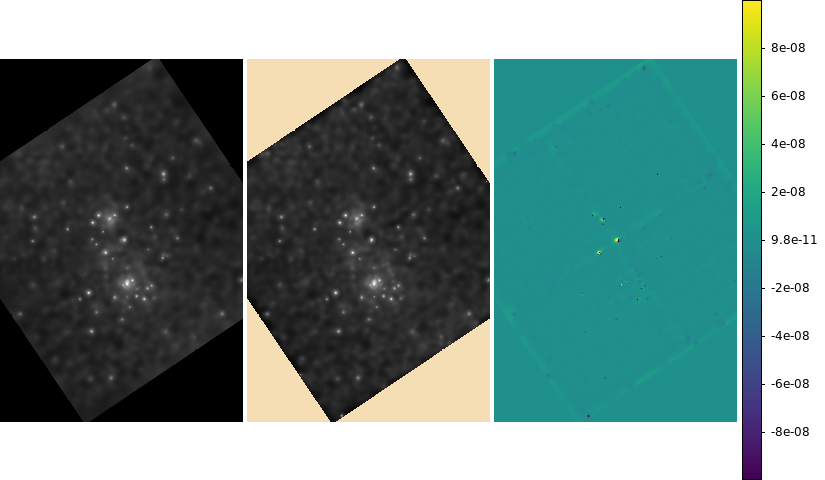

In [29]:
ds9 flux.asm -scale log -nan wheat -block 2 \
  easy_flux.asm   \
  -match scale -match scalelimits -match colorbar \
  diff_easy_flux.asm  -block 0.5 -zoom 0.5 \
  -cmap viridis -colorbar vertical \
  -scale limits -1.0E-7 1.0E-7 -scale linear \
  -tile mode column \
  -saveimage png ds9_09.png -quit

display < ds9_09.png  

    Left: Exposure corrected image created by smoothing counts and exposure separately.  Center: 
    The exposure corrected image by simply smoothing the fluxed image.  Right: difference between
    those two.  The two are not entirely equally comparable given the smoothing scales; however,
    in the Center image and difference image on the Right we do see residual effects associated 
    with the chip gaps and edges.  The effect is small since overall the exposure map does
    vary slowly; however in more complex images (say a mosaic with lots of chip edges from
    multiple observations) this effect may be more visible.